# Q1

Importing libraries:

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

In [1]:
from google.colab import drive
import scipy.io
drive.mount('/content/drive/')
import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive/


Reading data:

In [2]:
mask_data = scipy.io.loadmat("/content/drive/MyDrive/Data/HW2_AIMIA/ctscan_embeddings_hw2.mat")

In [3]:
print(mask_data)

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sat Nov 12 11:25:06 2022', '__version__': '1.0', '__globals__': [], 'feat': array([[0.30272228, 0.27103782, 0.26932836, ..., 0.21070398, 0.2310063 ,
        0.28865176],
       [0.28252736, 0.24100533, 0.23350462, ..., 0.18705425, 0.21686532,
        0.30654934],
       [0.282926  , 0.24257973, 0.23520353, ..., 0.18761976, 0.21674038,
        0.30464453],
       ...,
       [0.30039877, 0.26810023, 0.26617604, ..., 0.20713861, 0.22802743,
        0.28914464],
       [0.28513998, 0.24721071, 0.24088961, ..., 0.1896681 , 0.21658203,
        0.29945922],
       [0.28252736, 0.24100533, 0.23350462, ..., 0.18705425, 0.21686532,
        0.30654934]], dtype=float32)}


In [4]:
print(mask_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'feat'])


In [5]:
data=mask_data.get('feat')

In [6]:
print(data.shape)

(3554, 1024)


PCA for 100 and 50 dimentions:

In [9]:
# importing required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train=data
# X_train = sc.fit_transform(X_train)

In [11]:
# Applying PCA function on training
# and testing set of X component
from sklearn.decomposition import PCA
pca100 = PCA(n_components = 100)
X_train100 = pca100.fit_transform(X_train)

In [13]:
X_train100.shape

(3554, 100)

In [14]:
X_train100_reconstructed = pca100.inverse_transform(X_train100)
loss = np.sum((X_train - X_train100_reconstructed) ** 2,axis=1).mean()
print(loss)

1.2781538


Reconstruction MSE loss for PCA:

In [15]:
from sklearn.metrics import mean_squared_error
mean_squared_error(X_train, X_train100_reconstructed)

0.0012481969

In [72]:
pca50 = PCA(n_components = 50)
X_train50 = pca50.fit_transform(X_train)
X_train50_reconstructed = pca50.inverse_transform(X_train50)
mean_squared_error(X_train, X_train50_reconstructed)

0.00304137

In [73]:
l=[]
for i in range(20,1040,20):
  pca = PCA(n_components = i)
  X_train_i = pca.fit_transform(X_train)
  X_train_reconstructed = pca.inverse_transform(X_train_i)
  l.append(mean_squared_error(X_train, X_train_reconstructed))

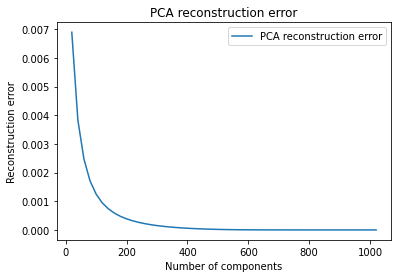

In [75]:
X=range(20,1040,20)
plt.plot(X,l,label='PCA reconstruction error')
plt.legend()
plt.title("PCA reconstruction error")
plt.xlabel("Number of components")
plt.ylabel("Reconstruction error")
plt.show()

# Q2

Choosing PCA size by elbow method. Above 300 components there is no gain:

In [7]:
PCA_components = 300

In [16]:
pca = PCA(n_components = PCA_components)
X_train_i = pca.fit_transform(X_train)
X_train_reconstructed = pca.inverse_transform(X_train_i)
mean_squared_error(X_train, X_train_reconstructed)

0.00015096157

Finding labels using infection area:

In [17]:
mask_data = scipy.io.loadmat("/content/drive/MyDrive/Data/HW/infmsk_hw1.mat")
mask = mask_data['infmsk']
print(mask.shape[2])
background_ctr = []
infection_ctr = []
healthy_ctr = []
mask=np.swapaxes(mask,0,2)
print(mask.shape)
for i in range(mask.shape[0]):
  background_ctr.append(np.count_nonzero(mask[i,:,:] == 0))
  infection_ctr.append(np.count_nonzero(mask[i,:,:] == 1))
  healthy_ctr.append(np.count_nonzero(mask[i,:,:] == 2))
infection_rate = []
category=[]
for i in range(mask.shape[0]):
  inf_rate = (infection_ctr[i]/(infection_ctr[i]+healthy_ctr[i])) * 100
  infection_rate.append(inf_rate)
for i in range(len(infection_rate)):
  if(infection_rate[i] == 0.0):
    category.append(0)
  if(infection_rate[i]> 0.0 and infection_rate[i] <= 40.0):
    category.append(1)
  if(infection_rate[i] > 40.0):
    category.append(2)

3554
(3554, 512, 512)


In [18]:
y=category

20% as test data:

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_train_i, y, test_size=0.20, random_state=42, shuffle=True)

In [20]:
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42, shuffle=True)

In [21]:
y_train=np.array(y_train)
y_train=np.reshape(y_train,(y_train.shape[0],1))
y_train.shape

(2843, 1)

Trying SVM without any hyperparameter tuning:

In [22]:
# import support vector classifier 
# "Support Vector Classifier"
from sklearn.svm import SVC

In [26]:
linear = SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train, y_train)
rbf = SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X_train, y_train)

In [23]:
y_train.shape

(2843, 1)

In [27]:
from sklearn.metrics import f1_score, accuracy_score
y_pred = linear.predict(X_test)
y_pred=np.reshape(y_pred,(y_pred.shape[0],1))
f1 = f1_score(y_test, y_pred, average=None)
print('F1 score: ', f1)
acc = accuracy_score(y_test, y_pred)
print('Accuracy: ',acc)

F1 score:  [0.93968254 0.94878706 0.92      ]
Accuracy:  0.9437412095639943


In [57]:
y_pred = rbf.predict(X_test)
y_pred=np.reshape(y_pred,(y_pred.shape[0],1))
f1 = f1_score(y_test, y_pred, average=None)
print('F1 score: ', f1)
acc = accuracy_score(y_test, y_pred)
print('Accuracy: ', acc)

F1 score:  [0.86738351 0.88038278 0.07142857]
Accuracy:  0.8593530239099859


Hypermarameter tuning for RBF using validation dataset:

Using 10% of entire dataset as validation and using 5-fold cross validation:

In [58]:
C_range = np.logspace(-3, 3, 7)
gamma_range = np.logspace(-3, 3, 7)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.125, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv) #default is rbf, ovo for multiclass classification
grid.fit(X_train, y_train)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

The best parameters are {'C': 1000.0, 'gamma': 0.01} with a score of 0.96


Test accuracy and F1:

In [28]:
rbf = SVC(kernel='rbf', gamma=0.01, C=1000, decision_function_shape='ovo').fit(X_train, y_train)
y_pred = rbf.predict(X_test)
y_pred=np.reshape(y_pred,(y_pred.shape[0],1))
f1 = f1_score(y_test, y_pred, average=None)
print('F1 score: ', f1)
acc = accuracy_score(y_test, y_pred)
print('Accuracy: ', acc)

F1 score:  [0.96116505 0.96533333 0.92592593]
Accuracy:  0.9620253164556962


In [29]:
from sklearn.metrics import confusion_matrix

Class-wise accuracy:

In [30]:
#Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)
#Now the normalize the diagonal entries
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#The diagonal entries are the accuracies of each class
cm.diagonal()

array([0.95806452, 0.96791444, 0.92592593])

Train accuracy and F1:

In [31]:
y_pred = rbf.predict(X_train)
y_pred=np.reshape(y_pred,(y_pred.shape[0],1))
f1 = f1_score(y_train, y_pred, average=None)
print('F1 score: ', f1)
acc = accuracy_score(y_train, y_pred)
print('Accuracy: ', acc)

F1 score:  [1. 1. 1.]
Accuracy:  1.0


Class-wise accuracy:

In [32]:
#Get the confusion matrix
cm = confusion_matrix(y_train, y_pred)
#Now the normalize the diagonal entries
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#The diagonal entries are the accuracies of each class
cm.diagonal()

array([1., 1., 1.])

Hyperparameter search for linear kernel:

Using 10% of dataset as validation and 5-fold cross validation.

In [39]:
C_range = np.logspace(-3, 3, 7)
param_grid = dict(C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.125, random_state=42)
grid = GridSearchCV(SVC(kernel='linear'), param_grid=param_grid, cv=cv) #default is rbf, ovo for multiclass classification
grid.fit(X_train, y_train)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

The best parameters are {'C': 1.0} with a score of 0.92


Test accuracy and F1 score:

In [35]:
linear = SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train, y_train)
y_pred = linear.predict(X_test)
y_pred=np.reshape(y_pred,(y_pred.shape[0],1))
f1 = f1_score(y_test, y_pred, average=None)
print('F1 score: ', f1)
acc = accuracy_score(y_test, y_pred)
print('Accuracy: ',acc)

F1 score:  [0.93968254 0.94878706 0.92      ]
Accuracy:  0.9437412095639943


Class-wise accuracy:

In [36]:
#Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)
#Now the normalize the diagonal entries
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#The diagonal entries are the accuracies of each class
cm.diagonal()

array([0.95483871, 0.94117647, 0.85185185])

Train set accuracy and F1 score:

In [37]:
y_pred = linear.predict(X_train)
y_pred=np.reshape(y_pred,(y_pred.shape[0],1))
f1 = f1_score(y_train, y_pred, average=None)
print('F1 score: ', f1)
acc = accuracy_score(y_train, y_pred)
print('Accuracy: ',acc)

F1 score:  [0.95275249 0.96445725 0.96875   ]
Accuracy:  0.9599015124868097


Class-wise accuracy:

In [38]:
#Get the confusion matrix
cm = confusion_matrix(y_train, y_pred)
#Now the normalize the diagonal entries
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#The diagonal entries are the accuracies of each class
cm.diagonal()

array([0.97170645, 0.95316456, 0.93939394])